# Linear Regression Starter Kit for Kaggle House Prices 

## Imports and inits

In [1]:
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch 
h2o.init() # give h2o as much memory as possible
h2o.no_progress() # turn off h2o progress bars

import numpy as np
import pandas as pd

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,33 mins 10 secs
H2O cluster version:,3.12.0.1
H2O cluster version age:,5 days
H2O cluster name:,H2O_from_python_phall_lp9n48
H2O cluster total nodes:,1
H2O cluster free memory:,3.066 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


## Import data

In [2]:
train = h2o.import_file('../data/train.csv')
test = h2o.import_file('../data/test.csv')

# bug fix - from Keston
dummy_col = np.random.rand(test.shape[0])
test = test.cbind(h2o.H2OFrame(dummy_col))
cols = test.columns
cols[-1] = 'SalePrice'
test.columns = cols
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 81)


#### Determine data types

In [3]:
def get_type_lists(frame=train, rejects=['Id', 'SalePrice']):

    """Creates lists of numeric and categorical variables.
    
    :param frame: The frame from which to determine types.
    :param rejects: Variable names not to be included in returned lists.
    :return: Tuple of lists for numeric and categorical variables in the frame.
    
    """
    
    nums, cats = [], []
    for key, val in frame.types.items():
        if key not in rejects:
            if val == 'enum':
                cats.append(key)
            else: 
                nums.append(key)
                
    print('Numeric =', nums)                
    print()
    print('Categorical =', cats)
    
    return nums, cats

In [4]:
original_nums, cats = get_type_lists()

Numeric = ['WoodDeckSF', 'MiscVal', 'MSSubClass', 'OverallQual', 'HalfBath', 'BsmtFullBath', 'BsmtFinSF2', '1stFlrSF', 'OverallCond', 'YrSold', 'MoSold', 'BsmtHalfBath', 'KitchenAbvGr', 'BedroomAbvGr', 'YearBuilt', '3SsnPorch', 'TotRmsAbvGrd', 'GarageYrBlt', 'BsmtUnfSF', 'GrLivArea', '2ndFlrSF', 'TotalBsmtSF', 'LotFrontage', 'LowQualFinSF', 'BsmtFinSF1', 'EnclosedPorch', 'GarageCars', 'PoolArea', 'Fireplaces', 'MasVnrArea', 'FullBath', 'GarageArea', 'LotArea', 'ScreenPorch', 'OpenPorchSF', 'YearRemodAdd']

Categorical = ['ExterCond', 'MiscFeature', 'PavedDrive', 'SaleType', 'LotShape', 'Neighborhood', 'LandSlope', 'GarageType', 'RoofStyle', 'Exterior2nd', 'BldgType', 'Functional', 'MSZoning', 'GarageFinish', 'Condition2', 'Foundation', 'Alley', 'LotConfig', 'RoofMatl', 'Electrical', 'Heating', 'KitchenQual', 'Utilities', 'HeatingQC', 'BsmtFinType2', 'GarageQual', 'FireplaceQu', 'BsmtQual', 'CentralAir', 'Street', 'HouseStyle', 'ExterQual', 'SaleCondition', 'LandContour', 'MasVnrType', 

## Split into to train and validation (before doing data prep!!!)

In [5]:
train, valid = train.split_frame([0.7], seed=12345)
print(train.shape)
print(valid.shape)

(1001, 81)
(459, 81)


## Impute numeric missing

In [6]:
# median usually better than mean
# (_ signifies temporary throw-away variable, used to suppress output)
_ = train[['MasVnrArea', 'GarageYrBlt', 'LotFrontage']].impute(method='median')
_ = valid[['MasVnrArea', 'GarageYrBlt', 'LotFrontage']].impute(method='median')
_ = test[['BsmtHalfBath', 'BsmtFinSF1', 'BsmtFullBath', 'BsmtFinSF2', 'BsmtUnfSF', 'MasVnrArea', 
          'GarageYrBlt', 'LotFrontage', 'GarageCars', 'TotalBsmtSF', 'GarageArea']].impute(method='median')

## Encode categorical vars using shrunken averages
http://helios.mm.di.uoa.gr/~rouvas/ssi/sigkdd/sigkdd.vol3.1/barreca.ps

In [7]:
def target_encoder(training_frame, test_frame, x, y, lambda_=0.15, threshold=150, test=False):

    """ Applies simple target encoding to categorical variables.

    :param training_frame: Training frame which to create target means and to be encoded.
    :param test_frame: Test frame to be encoded using information from training frame.
    :param x: Name of input variable to be encoded.
    :param y: Name of target variable to use for encoding.
    :param lambda_: Balance between level mean and overall mean for small groups.
    :param threshold: Number below which a level is considered small enough to be shrunken.
    :param test: Whether or not to print the row_val_dict for testing purposes.
    :return: Tuple of encoded variable from train and test set as H2OFrames.

    """

    # convert to pandas
    trdf = training_frame.as_data_frame().loc[:, [x,y]] # df
    tss = test_frame.as_data_frame().loc[:, x]          # series


    # create dictionary of level:encode val

    encode_name = x + '_Tencode'
    overall_mean = trdf[y].mean()
    row_val_dict = {}

    for level in trdf[x].unique():
        level_df = trdf[trdf[x] == level][y]
        level_n = level_df.shape[0]
        level_mean = level_df.mean()
        if level_n >= threshold:
            row_val_dict[level] = level_mean
        else:
            row_val_dict[level] = ((1 - lambda_) * level_mean) +\
                                  (lambda_ * overall_mean)

    row_val_dict[np.nan] = overall_mean # handle missing values

    if test:
        print(row_val_dict)

    # apply the transform to training data
    trdf[encode_name] = trdf[x].apply(lambda i: row_val_dict[i])

    # apply the transform to test data
    tsdf = pd.DataFrame(columns=[x, encode_name])
    tsdf[x] = tss
    tsdf.loc[:, encode_name] = overall_mean # handle previously unseen values
    # handle values that are seen in tsdf but not row_val_dict
    for i, col_i in enumerate(tsdf[x]):
        try:
            row_val_dict[col_i]
        except:
            # a value that appeared in tsdf isn't in the row_val_dict so just
            # make it the overall_mean
            row_val_dict[col_i] = overall_mean
    tsdf[encode_name] = tsdf[x].apply(lambda i: row_val_dict[i])


    # convert back to H2O

    trdf = h2o.H2OFrame(trdf[encode_name].as_matrix())
    trdf.columns = [encode_name]

    tsdf = h2o.H2OFrame(tsdf[encode_name].as_matrix())
    tsdf.columns = [encode_name]

    return (trdf, tsdf)


#### Execute encoding

In [8]:
total = len(cats)
for i, var in enumerate(cats):
    
    tr_enc, _ = target_encoder(train, test, var, 'SalePrice')
    v_enc, ts_enc = target_encoder(valid, test, var, 'SalePrice')
    
    print('Encoding: ' + var + ' (' + str(i+1) + '/' + str(total) + ') ...')

    train = train.cbind(tr_enc)
    valid = valid.cbind(v_enc)
    test = test.cbind(ts_enc)    
    
print('Done.')

Encoding: ExterCond (1/43) ...
Encoding: MiscFeature (2/43) ...
Encoding: PavedDrive (3/43) ...
Encoding: SaleType (4/43) ...
Encoding: LotShape (5/43) ...
Encoding: Neighborhood (6/43) ...
Encoding: LandSlope (7/43) ...
Encoding: GarageType (8/43) ...
Encoding: RoofStyle (9/43) ...
Encoding: Exterior2nd (10/43) ...
Encoding: BldgType (11/43) ...
Encoding: Functional (12/43) ...
Encoding: MSZoning (13/43) ...
Encoding: GarageFinish (14/43) ...
Encoding: Condition2 (15/43) ...
Encoding: Foundation (16/43) ...
Encoding: Alley (17/43) ...
Encoding: LotConfig (18/43) ...
Encoding: RoofMatl (19/43) ...
Encoding: Electrical (20/43) ...
Encoding: Heating (21/43) ...
Encoding: KitchenQual (22/43) ...
Encoding: Utilities (23/43) ...
Encoding: HeatingQC (24/43) ...
Encoding: BsmtFinType2 (25/43) ...
Encoding: GarageQual (26/43) ...
Encoding: FireplaceQu (27/43) ...
Encoding: BsmtQual (28/43) ...
Encoding: CentralAir (29/43) ...
Encoding: Street (30/43) ...
Encoding: HouseStyle (31/43) ...
Encodi

#### Redefine numerics and explore

In [9]:
encoded_nums, cats = get_type_lists(frame=train)

Numeric = ['WoodDeckSF', 'HouseStyle_Tencode', 'GarageFinish_Tencode', 'FireplaceQu_Tencode', 'Neighborhood_Tencode', 'MiscVal', 'MSSubClass', 'OverallQual', 'HalfBath', 'BsmtExposure_Tencode', 'GarageType_Tencode', 'BsmtUnfSF', 'SaleType_Tencode', 'ExterQual_Tencode', 'BsmtFinSF1', 'RoofStyle_Tencode', 'BsmtFullBath', 'KitchenQual_Tencode', 'Utilities_Tencode', 'Alley_Tencode', 'CentralAir_Tencode', '1stFlrSF', 'OverallCond', 'ExterCond_Tencode', 'YrSold', 'MoSold', 'BsmtHalfBath', 'KitchenAbvGr', 'LotShape_Tencode', 'HeatingQC_Tencode', 'BedroomAbvGr', 'YearBuilt', '3SsnPorch', 'TotRmsAbvGrd', 'LotFrontage', 'SaleCondition_Tencode', 'MasVnrType_Tencode', 'GrLivArea', 'GarageCond_Tencode', 'LotArea', '2ndFlrSF', 'MSZoning_Tencode', 'LotConfig_Tencode', 'TotalBsmtSF', 'Exterior1st_Tencode', 'PavedDrive_Tencode', 'Heating_Tencode', 'LowQualFinSF', 'BsmtQual_Tencode', 'BsmtFinType2_Tencode', 'GarageYrBlt', 'Street_Tencode', 'EnclosedPorch', 'RoofMatl_Tencode', 'GarageCars', 'PoolArea', '

In [10]:
print('Imputed and encoded numeric training data:')
train[encoded_nums].describe() #79 numeric columns w/ no missing
print('--------------------------------------------------------------------------------')
print('Imputed and encoded numeric validation data:')
valid[encoded_nums].describe() #79 numeric columns w/ no missing
print('--------------------------------------------------------------------------------')
print('Imputed and encoded numeric test data:')
test[encoded_nums].describe() #79 numeric columns w/ no missing

Imputed and encoded numeric training data:
Rows:1001
Cols:79




,WoodDeckSF,HouseStyle_Tencode,GarageFinish_Tencode,FireplaceQu_Tencode,Neighborhood_Tencode,MiscVal,MSSubClass,OverallQual,HalfBath,BsmtExposure_Tencode,GarageType_Tencode,BsmtUnfSF,SaleType_Tencode,ExterQual_Tencode,BsmtFinSF1,RoofStyle_Tencode,BsmtFullBath,KitchenQual_Tencode,Utilities_Tencode,Alley_Tencode,CentralAir_Tencode,1stFlrSF,OverallCond,ExterCond_Tencode,YrSold,MoSold,BsmtHalfBath,KitchenAbvGr,LotShape_Tencode,HeatingQC_Tencode,BedroomAbvGr,YearBuilt,3SsnPorch,TotRmsAbvGrd,LotFrontage,SaleCondition_Tencode,MasVnrType_Tencode,GrLivArea,GarageCond_Tencode,LotArea,2ndFlrSF,MSZoning_Tencode,LotConfig_Tencode,TotalBsmtSF,Exterior1st_Tencode,PavedDrive_Tencode,Heating_Tencode,LowQualFinSF,BsmtQual_Tencode,BsmtFinType2_Tencode,GarageYrBlt,Street_Tencode,EnclosedPorch,RoofMatl_Tencode,GarageCars,PoolArea,LandSlope_Tencode,Foundation_Tencode,MiscFeature_Tencode,Fireplaces,MasVnrArea,Condition1_Tencode,Fence_Tencode,Electrical_Tencode,FullBath,GarageQual_Tencode,GarageArea,PoolQC_Tencode,BsmtFinSF2,LandContour_Tencode,ScreenPorch,Condition2_Tencode,Exterior2nd_Tencode,BsmtCond_Tencode,OpenPorchSF,YearRemodAdd,BsmtFinType1_Tencode,BldgType_Tencode,Functional_Tencode
type,int,real,real,real,real,int,int,int,int,real,real,int,real,real,int,real,int,real,real,real,real,int,int,real,int,int,int,int,real,real,int,int,int,int,real,real,real,int,real,int,int,real,real,int,real,real,real,int,real,real,real,real,int,real,int,int,real,real,real,int,real,real,real,real,int,real,int,real,int,real,int,real,real,real,int,int,real,real,real
mins,0.0,118907.22242757239,141354.57177033494,141462.34885614386,109690.79385614385,0.0,20.0,2.0,0.0,167645.4123076923,125174.9605228105,0.0,125968.29385614385,116078.96885614384,0.0,161577.2224275724,0.0,124936.94820396995,144200.79385614386,128075.200999001,119608.23368665231,480.0,2.0,122047.14941169939,2006.0,1.0,0.0,0.0,163944.59385614382,135668.69902855766,0.0,1875.0,0.0,3.0,21.0,115832.04385614385,155578.6188811189,480.0,112070.79385614385,1300.0,0.0,78614.79385614385,176473.2899159664,0.0,78325.79385614385,129253.89464979463,93469.96052281052,0.0,121216.12093947716,154536.9355228105,1908.0,146350.10385614386,0.0,143775.79385614386,0.0,0.0,181486.5182747485,121726.89385614387,140375.79385614386,0.0,0.0,134468.29385614386,141306.73814185814,84275.79385614385,0.0,96813.29385614385,0.0,182171.95904095902,0.0,145140.16285614387,0.0,108075.79385614385,129978.23968947721,84275.79385614385,0.0,1950.0,150410.4464877228,138273.46052281052,110059.12718947718
mean,91.07392607392607,183188.25635258848,185712.8721618042,200266.80114860163,182171.95904095905,39.684315684315685,57.08791208791209,6.1448551448551445,0.38161838161838163,182844.62529074325,185255.62265751234,575.99000999001,181180.3311701286,181095.69602749898,445.5994005994006,182159.0086938536,0.42657342657342656,180810.97023994988,182178.65314071544,180171.38546862727,182822.70708043204,1172.0889110889111,5.583416583416583,182637.23505924645,2007.828171828172,6.362637362637362,0.059940059940059943,1.046953046953047,181993.92786324563,182409.7085632649,2.871128871128871,1972.2987012987012,3.4565434565434567,6.512487512487512,70.59975669099758,181541.32494458588,180574.40004970055,1519.8011988011988,186002.74671607107,10628.262737262738,341.7872127872128,183387.92640181992,181772.16118142597,1063.2387612387613,183565.71379414792,182908.18055950044,182323.57985955098,5.9250749250749255,182245.41278741238,184056.75787594018,1978.734522560336,182203.5349842964,21.257742257742258,182033.94005549894,1.7932067932067932,3.3766233766233764,182145.0556687069,183119.90242260235,181198.19224147475,0.6203796203796204,106.91146881287727,182645.11776425372,177450.87030976015,182952.64128239392,1.5744255744255744,186018.3297154893,477.46853146853147,182802.82568320786,41.64935064935065,182186.73299732237,14.763236763236764,182224.4420403772,183994.52609268852,184043.11900766566,44.92407592407592,1985.138861138861,185645.79515235015,182849.79797600003,182576.245

--------------------------------------------------------------------------------
Imputed and encoded numeric validation data:
Rows:459
Cols:79




,WoodDeckSF,HouseStyle_Tencode,GarageFinish_Tencode,FireplaceQu_Tencode,Neighborhood_Tencode,MiscVal,MSSubClass,OverallQual,HalfBath,BsmtExposure_Tencode,GarageType_Tencode,BsmtUnfSF,SaleType_Tencode,ExterQual_Tencode,BsmtFinSF1,RoofStyle_Tencode,BsmtFullBath,KitchenQual_Tencode,Utilities_Tencode,Alley_Tencode,CentralAir_Tencode,1stFlrSF,OverallCond,ExterCond_Tencode,YrSold,MoSold,BsmtHalfBath,KitchenAbvGr,LotShape_Tencode,HeatingQC_Tencode,BedroomAbvGr,YearBuilt,3SsnPorch,TotRmsAbvGrd,LotFrontage,SaleCondition_Tencode,MasVnrType_Tencode,GrLivArea,GarageCond_Tencode,LotArea,2ndFlrSF,MSZoning_Tencode,LotConfig_Tencode,TotalBsmtSF,Exterior1st_Tencode,PavedDrive_Tencode,Heating_Tencode,LowQualFinSF,BsmtQual_Tencode,BsmtFinType2_Tencode,GarageYrBlt,Street_Tencode,EnclosedPorch,RoofMatl_Tencode,GarageCars,PoolArea,LandSlope_Tencode,Foundation_Tencode,MiscFeature_Tencode,Fireplaces,MasVnrArea,Condition1_Tencode,Fence_Tencode,Electrical_Tencode,FullBath,GarageQual_Tencode,GarageArea,PoolQC_Tencode,BsmtFinSF2,LandContour_Tencode,ScreenPorch,Condition2_Tencode,Exterior2nd_Tencode,BsmtCond_Tencode,OpenPorchSF,YearRemodAdd,BsmtFinType1_Tencode,BldgType_Tencode,Functional_Tencode
type,int,real,real,real,real,int,int,int,int,real,real,int,real,real,int,real,int,real,real,real,real,int,int,real,int,int,int,int,real,real,int,int,int,int,real,real,real,int,real,int,int,real,real,int,real,real,real,int,real,real,real,real,int,real,int,int,real,real,real,int,real,real,real,real,int,real,int,real,int,real,int,real,real,real,int,int,real,real,real
mins,0.0,122402.59593837534,143948.79679144386,133191.52450980392,112866.7168174962,0.0,20.0,1.0,0.0,161376.63366336632,111434.07450980392,0.0,107734.02450980392,91042.14950980392,0.0,139864.02450980392,0.0,105130.89950980392,178193.4967320261,134607.54723707662,111601.52450980392,334.0,1.0,91754.02450980392,2006.0,1.0,0.0,1.0,163981.4191419142,100679.02450980392,0.0,1872.0,0.0,2.0,21.0,143816.52450980392,131576.52450980392,334.0,118776.94117647059,1491.0,0.0,118217.35784313723,165751.57330498463,0.0,96429.02450980392,114840.96895424835,77729.02450980392,0.0,134771.7517825312,145091.52450980392,1900.0,95579.02450980392,0.0,175904.02450980392,0.0,0.0,175531.83179723503,110363.31736694675,73479.02450980392,0.0,0.0,150223.0311764706,133419.96200980392,100143.52450980392,0.0,134853.20367647058,0.0,178193.4967320261,0.0,163075.56297134238,0.0,84954.02450980392,106204.02450980392,78579.02450980392,0.0,1950.0,146338.19117647054,128987.56617647059,84954.02450980392
mean,101.15904139433552,177648.76674783204,181122.03431372548,194587.7731541999,178193.49673202613,51.78649237472767,56.48148148148148,6.0,0.38562091503267976,178366.110436157,185134.53079371178,548.1590413943355,177239.63702422145,174940.2994916485,439.36601307189545,177381.1458157119,0.4226579520697168,177298.2844312017,178193.49673202608,176164.9969256838,179115.18492887347,1141.9912854030501,5.557734204793029,178484.55631381093,2007.7886710239652,6.233115468409586,0.05228758169934641,1.0457516339869282,176786.22238241704,180663.6615169379,2.8562091503267975,1969.0196078431372,3.30718954248366,6.529411764705882,68.85751978891821,177335.48292323467,176108.20460862629,1506.004357298475,184432.0126553889,10273.808278867102,358.3442265795207,179328.32668845312,178163.26637404418,1044.7603485838779,179651.10523303002,179002.9605814003,178371.04867785895,5.668845315904139,179069.59942970652,180587.69974155238,1977.9953051643192,178225.25931265755,23.47276688453159,177969.71943483275,1.710239651416122,1.411764705882353,177815.9926203597,179041.90369302404,177409.66351972884,0.5969498910675382,96.68340611353712,178617.62590029472,173941.1787702735,179083.62772865137,1.5446623093681917,184195.2038275876,463.1917211328976,178198.69396030012,57.23529411764706,177854.22806185653,15.710239651416122,178197.18104147978,179728.60882139349,180413.2355397497,50.446623093681914,1984.2701525054467,180031.30962236744,178649.14910504507,178425.73264556366
maxs,857.0,22

--------------------------------------------------------------------------------
Imputed and encoded numeric test data:
Rows:1459
Cols:79




,WoodDeckSF,HouseStyle_Tencode,GarageFinish_Tencode,FireplaceQu_Tencode,Neighborhood_Tencode,MiscVal,MSSubClass,OverallQual,HalfBath,BsmtExposure_Tencode,GarageType_Tencode,BsmtUnfSF,SaleType_Tencode,ExterQual_Tencode,BsmtFinSF1,RoofStyle_Tencode,BsmtFullBath,KitchenQual_Tencode,Utilities_Tencode,Alley_Tencode,CentralAir_Tencode,1stFlrSF,OverallCond,ExterCond_Tencode,YrSold,MoSold,BsmtHalfBath,KitchenAbvGr,LotShape_Tencode,HeatingQC_Tencode,BedroomAbvGr,YearBuilt,3SsnPorch,TotRmsAbvGrd,LotFrontage,SaleCondition_Tencode,MasVnrType_Tencode,GrLivArea,GarageCond_Tencode,LotArea,2ndFlrSF,MSZoning_Tencode,LotConfig_Tencode,TotalBsmtSF,Exterior1st_Tencode,PavedDrive_Tencode,Heating_Tencode,LowQualFinSF,BsmtQual_Tencode,BsmtFinType2_Tencode,GarageYrBlt,Street_Tencode,EnclosedPorch,RoofMatl_Tencode,GarageCars,PoolArea,LandSlope_Tencode,Foundation_Tencode,MiscFeature_Tencode,Fireplaces,MasVnrArea,Condition1_Tencode,Fence_Tencode,Electrical_Tencode,FullBath,GarageQual_Tencode,GarageArea,PoolQC_Tencode,BsmtFinSF2,LandContour_Tencode,ScreenPorch,Condition2_Tencode,Exterior2nd_Tencode,BsmtCond_Tencode,OpenPorchSF,YearRemodAdd,BsmtFinType1_Tencode,BldgType_Tencode,Functional_Tencode
type,int,real,real,real,real,int,int,int,int,real,real,real,real,real,real,real,real,real,real,real,real,int,int,real,int,int,real,int,real,real,int,int,int,int,real,real,real,int,real,int,int,real,real,real,real,real,real,int,real,real,real,real,int,real,real,int,real,real,real,int,real,real,real,real,int,real,real,real,real,real,int,real,real,real,int,int,real,real,real
mins,0.0,122402.59593837534,143948.79679144386,133191.52450980392,112866.7168174962,0.0,20.0,1.0,0.0,161376.63366336632,111434.07450980392,0.0,107734.02450980392,91042.14950980392,0.0,139864.02450980392,0.0,105130.89950980392,178193.4967320261,134607.54723707662,111601.52450980392,407.0,1.0,91754.02450980392,2006.0,1.0,0.0,0.0,163981.4191419142,100679.02450980392,0.0,1879.0,0.0,3.0,21.0,143816.52450980392,131576.52450980392,407.0,118776.94117647059,1470.0,0.0,118217.35784313723,165751.57330498463,0.0,96429.02450980392,114840.96895424835,77729.02450980392,0.0,134771.7517825312,145091.52450980392,1895.0,95579.02450980392,0.0,175904.02450980392,0.0,0.0,175531.83179723503,110363.31736694675,73479.02450980392,0.0,0.0,150223.0311764706,133419.96200980392,100143.52450980392,0.0,134853.20367647058,0.0,178193.4967320261,0.0,163075.56297134238,0.0,127029.02450980392,106204.02450980392,78579.02450980392,0.0,1950.0,146338.19117647054,128987.56617647059,84954.02450980392
mean,93.17477724468814,176296.0327526845,180987.1789957136,194452.82035270397,179660.9318538107,58.16792323509253,57.37834132967786,6.078821110349555,0.3776559287183002,179354.8610184363,186339.7089378328,554.2949245541838,175933.10715345875,177673.68837649448,439.2037037037037,177370.7037166422,0.4344543582704186,179340.3962464452,178193.4967320261,176172.85149770897,179789.60281035837,1156.534612748458,5.5538039753255655,178138.29247727426,2007.7697052775875,6.104180945853324,0.06520247083047358,1.0424948594928032,176844.0836371834,182227.81273899964,2.8540095956134337,1971.357779300891,1.794379712131597,6.385195339273475,68.58035714285714,176492.09637795313,178207.07986924512,1486.0459218642907,184620.93755108098,9819.161069225496,325.9677861549006,179232.09043019178,178278.00897433652,1046.1179698216736,179810.686881209,177090.15440559445,179140.34833949362,3.5435229609321452,181062.10689687656,180689.57815766838,1977.7212165097756,178065.09267032953,24.24331734064427,176751.75320615337,1.7661179698216736,1.7443454420836186,177395.21920765378,181006.2901857593,177606.24421888925,0.5812200137080192,100.70914127423823,179939.77372747526,174246.9783571091,180126.1193152811,1.570938999314599,182567.66333366183,472.7688614540466,178193.4967320261,52.61934156378601,179174.226337526,17.064427690198766,178369.39980873463,180995.23531825157,179283.61725237884,48.3139136394791,1983.6627827278958,182091.99147253158,178370.36965515942,178383.0372094

In [11]:
# Check Neighborhood_Tencode

print(test[0:5, ['Neighborhood', 'Neighborhood_Tencode']])
_, _ = target_encoder(valid, test, 'Neighborhood', 'SalePrice', test=True)
del _

# NAmes   152080
# NAmes   152080
# Gilbert 191808
# Gilbert 191808
# StoneBr 288359

Neighborhood,Neighborhood_Tencode
NAmes,152080
NAmes,152080
Gilbert,191808
Gilbert,191808
StoneBr,288359



{nan: 178193.49673202613, 'IDOTRR': 112866.71681749621, 'CollgCr': 190019.77971813726, 'SWISU': 156269.02450980392, 'Edwards': 126241.13989441929, 'StoneBr': 288359.0245098039, 'NAmes': 152080.32258672698, 'Veenker': 243734.02450980392, 'NridgHt': 284073.1545098039, 'NoRidge': 273948.2552790347, 'Sawyer': 143162.40700980392, 'Timber': 260109.74673202613, 'NPkVill': 147641.52450980392, 'BrDale': 116064.02450980392, 'Crawfor': 216008.84593837534, 'OldTown': 139863.03613771088, 'Gilbert': 191808.0596949891, 'Mitchel': 169316.52450980392, 'BrkSide': 129965.77450980392, 'NWAmes': 184610.14950980392, 'Blmngtn': 210845.6545098039, 'MeadowV': 113131.52450980392, 'ClearCr': 207949.02450980392, 'Somerst': 227656.9671023965, 'SawyerW': 189097.7776348039}


## Create combination features

In [12]:
def feature_combiner(training_frame, test_frame, nums):
    
    """ Combines numeric features using simple arithmatic operations.
    
    :param training_frame: Training frame from which to generate features and onto which generated 
                           feeatures will be cbound.
    :param test_frame: Test frame from which to generate features and onto which generated 
                       feeatures will be cbound.
    :param nums: List of original numeric features from which to generate combined features.
    
    """

    total = len(nums)
    
    # convert to pandas
    train_df = training_frame.as_data_frame()
    test_df = test_frame.as_data_frame()
    
    for i, col_i in enumerate(nums):
        
        print('Combining: ' + col_i + ' (' + str(i+1) + '/' + str(total) + ') ...')        
        
        for j, col_j in enumerate(nums):
            
            # don't repeat (i*j = j*i)
            if i < j:
                
                # convert to pandas
                col_i_train_df = train_df[col_i]
                col_j_train_df = train_df[col_j]
                col_i_test_df = test_df[col_i]
                col_j_test_df = test_df[col_j] 

                # multiply, convert back to h2o
                train_df[str(col_i + '|' + col_j)] = col_i_train_df.values*col_j_train_df.values
                test_df[str(col_i + '|' + col_j)] = col_i_test_df.values*col_j_test_df.values
                
    print('Done.')
    
    # convert back to h2o
    
    print('Converting to H2OFrame ...')
    
    training_frame = h2o.H2OFrame(train_df)
    training_frame.columns = list(train_df)
    test_frame = h2o.H2OFrame(test_df)
    test_frame.columns = list(test_df)
    
    print('Done.')
    print()
    
    # conserve memory 
    del train_df
    del test_df 
    
    return training_frame, test_frame


In [13]:
train, _ = feature_combiner(train, test, encoded_nums)
valid, test = feature_combiner(valid, test, encoded_nums)

Combining: WoodDeckSF (1/79) ...
Combining: HouseStyle_Tencode (2/79) ...
Combining: GarageFinish_Tencode (3/79) ...
Combining: FireplaceQu_Tencode (4/79) ...
Combining: Neighborhood_Tencode (5/79) ...
Combining: MiscVal (6/79) ...
Combining: MSSubClass (7/79) ...
Combining: OverallQual (8/79) ...
Combining: HalfBath (9/79) ...
Combining: BsmtExposure_Tencode (10/79) ...
Combining: GarageType_Tencode (11/79) ...
Combining: BsmtUnfSF (12/79) ...
Combining: SaleType_Tencode (13/79) ...
Combining: ExterQual_Tencode (14/79) ...
Combining: BsmtFinSF1 (15/79) ...
Combining: RoofStyle_Tencode (16/79) ...
Combining: BsmtFullBath (17/79) ...
Combining: KitchenQual_Tencode (18/79) ...
Combining: Utilities_Tencode (19/79) ...
Combining: Alley_Tencode (20/79) ...
Combining: CentralAir_Tencode (21/79) ...
Combining: 1stFlrSF (22/79) ...
Combining: OverallCond (23/79) ...
Combining: ExterCond_Tencode (24/79) ...
Combining: YrSold (25/79) ...
Combining: MoSold (26/79) ...
Combining: BsmtHalfBath (27/

#### Redefine numerics and explore

In [14]:
encoded_combined_nums, cats = get_type_lists(frame=train)

Numeric = ['YrSold|RoofMatl_Tencode', 'HouseStyle_Tencode|GarageFinish_Tencode', 'RoofStyle_Tencode|Foundation_Tencode', '1stFlrSF', 'HalfBath|RoofStyle_Tencode', 'ExterCond_Tencode|LowQualFinSF', 'HalfBath|CentralAir_Tencode', 'WoodDeckSF|RoofStyle_Tencode', '1stFlrSF|Fence_Tencode', '3SsnPorch|ScreenPorch', 'HalfBath|Fireplaces', 'OverallCond|Foundation_Tencode', 'LotArea|GarageCars', 'FireplaceQu_Tencode|BsmtFinSF2', 'ExterQual_Tencode', 'GarageCond_Tencode|EnclosedPorch', 'Alley_Tencode|LotConfig_Tencode', 'GrLivArea|PoolQC_Tencode', 'Neighborhood_Tencode|Fence_Tencode', 'BsmtFullBath|MoSold', 'BsmtFullBath|PavedDrive_Tencode', 'WoodDeckSF|Exterior2nd_Tencode', 'GarageType_Tencode|LandContour_Tencode', 'SaleType_Tencode|YearRemodAdd', 'Neighborhood_Tencode|RoofStyle_Tencode', 'BedroomAbvGr|LowQualFinSF', 'HeatingQC_Tencode|PoolQC_Tencode', 'CentralAir_Tencode|1stFlrSF', 'GarageFinish_Tencode|CentralAir_Tencode', 'SaleType_Tencode|LotFrontage', 'LotFrontage|LandSlope_Tencode', 'Bsmt

In [15]:
# check number of created variables is correct
# 1 id column, 1 target column, 79 original + encoded numeric columns, 43 original categorical variables
# sum(range(1, 79)) combined variables
print(train.shape == (1001, sum(range(1, 79), (79 + 43 + 1 + 1))))
print(test.shape == (1459, sum(range(1, 79), (79 + 43 + 1 + 1))))

True
True


In [16]:
# check multiplication for a random column
ridx = np.random.choice(sum(range(1, 79)))
combined_only = [name for name in encoded_combined_nums if name not in encoded_nums]
combined_check_vars = combined_only[ridx].split('|')
combined_check_vars.append(combined_only[ridx])

print(train[736, combined_check_vars])
print(test[637, combined_check_vars])

print(train[736, combined_check_vars[0]]*train[736, combined_check_vars[1]])
print(test[637, combined_check_vars[0]]*test[637, combined_check_vars[1]])

SaleType_Tencode,1stFlrSF,SaleType_Tencode|1stFlrSF
174574,1096,1.91334e+08


SaleType_Tencode,1stFlrSF,SaleType_Tencode|1stFlrSF
170823,904,1.54424e+08



191333555.73823193
154423777.4141414


## Train models

In [17]:
h2o.show_progress()                                          # turn on progress bars
from h2o.estimators.glm import H2OGeneralizedLinearEstimator # import GLM models
from h2o.grid.grid_search import H2OGridSearch               # grid search

SalePrice
12.2477
12.109
12.3172


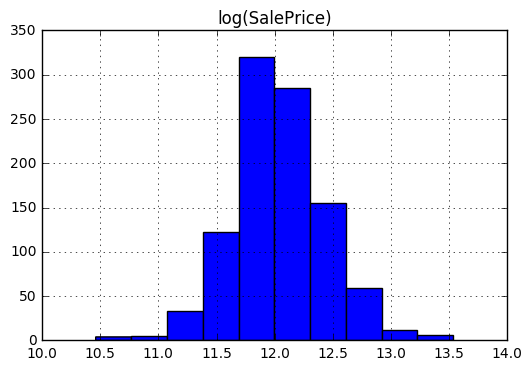

In [18]:
# Check log transform - looks good
%matplotlib inline
train['SalePrice'].log().as_data_frame().hist()

# Execute log transform
train['SalePrice'] = train['SalePrice'].log()
valid['SalePrice'] = valid['SalePrice'].log()
print(train[0:3, 'SalePrice'])

#### Split training data

In [19]:
half_train, other_half_train = train.split_frame([0.5], seed=12345)
half_valid, other_half_valid = valid.split_frame([0.5], seed=12345)
print(half_train.shape)
print(half_valid.shape)
print(other_half_train.shape)
print(other_half_valid.shape)
# no idea why this works better, but it does ... 
# could be a lucky split that happens to be more representative of test data
# could be that it just prevents overfitting

(504, 3205)
(230, 3205)
(497, 3205)
(229, 3205)


#### Define model with grid search function

In [20]:
def glm_grid(X, y, train, valid):
    
    """ Wrapper function for penalized GLM with alpha and lambda search.
    
    :param X: List of inputs.
    :param y: Name of target variable.
    :param train: Name of training H2OFrame.
    :param valid: Name of validation H2OFrame.
    :return: Best H2Omodel from H2OGeneralizedLinearEstimator

    """
    
    alpha_opts = [0.01, 0.25, 0.5, 0.99] # always keep some L2
    hyper_parameters = {"alpha":alpha_opts}

    # initialize grid search
    grid = H2OGridSearch(
        H2OGeneralizedLinearEstimator(
            family="gaussian",
            lambda_search=True,
            seed=12345),
        hyper_params=hyper_parameters)
    
    # train grid
    grid.train(y=y,
               x=X, 
               training_frame=train,
               validation_frame=valid)

    # show grid search results
    print(grid.show())

    best = grid.get_grid()[0]
    print(best)
    
    # plot top frame values
    yhat_frame = valid.cbind(best.predict(valid))
    print(yhat_frame[0:10, [y, 'predict']])

    # plot sorted predictions
    yhat_frame_df = yhat_frame[[y, 'predict']].as_data_frame()
    yhat_frame_df.sort_values(by='predict', inplace=True)
    yhat_frame_df.reset_index(inplace=True, drop=True)
    _ = yhat_frame_df.plot(title='Ranked Predictions Plot')
    
    # select best model
    return best


#### Function to generate submission file

In [55]:
import re
import time

def gen_submission(model, test=test):

    """ Generates submission file for Kaggle House Prices contest.
    
    :param model: Model with which to score test data.
    :param test: Test data.
    
    """
    
    # create time stamp
    time_stamp = re.sub('[: ]', '_', time.asctime())

    # create predictions column
    sub = test['Id'].cbind(model.predict(test).exp())
    sub.columns = ['Id', 'SalePrice']
    
    # save file for submission
    sub_fname = '../data/submission_' + str(time_stamp) + '.csv'
    h2o.download_csv(sub, sub_fname)


#### Simple function to average predictions

In [52]:
import os

def pred_blender(dir_, files):
    
    """ Performs simple blending of prediction files. 
    
    :param dir_: Directory in which files to be read are stored.
    :param files: List of prediction files to be blended.
    
    """
    
    # read predictions in files list and cbind
    for i, file in enumerate(files):
        if i == 0:
            df = pd.read_csv(dir_ + os.sep + file).drop('SalePrice', axis=1)
        col = pd.read_csv(dir_ + os.sep + file).drop('Id', axis=1)
        col.columns = ['SalePrice' + str(i)]
        df = pd.concat([df, col], axis=1)
        
    # create mean prediction    
    df['mean'] = df.iloc[:, 1:].mean(axis=1)
    print(df.head())
        
    # create time stamp
    time_stamp = re.sub('[: ]', '_', time.asctime())        
        
    # write new submission file    
    df = df[['Id', 'mean']]
    df.columns = ['Id', 'SalePrice']
    
    # save file for submission
    sub_fname = '../data/submission_' + str(time_stamp) + '.csv'
    df.to_csv(sub_fname, index=False)
     

#### First model on original numeric inputs

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0    [0.99]  Grid_GLM_py_288_sid_a7cd_model_python_1497309861992_3_model_3   
1     [0.5]  Grid_GLM_py_288_sid_a7cd_model_python_1497309861992_3_model_2   
2    [0.25]  Grid_GLM_py_288_sid_a7cd_model_python_1497309861992_3_model_1   
3    [0.01]  Grid_GLM_py_288_sid_a7cd_model_python_1497309861992_3_model_0   

   residual_deviance  
0  4.025940991543426  
1  4.037235202840883  
2  4.058507339499796  
3  4.491994155264081  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_288_sid_a7cd_model_python_1497309861992_3_model_3


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.021564404839388217
RMSE: 0.146848237440523
MAE: 0.09686367637083063
RMSLE: 0.011364228341693757
R^2: 0.862319569887144
Mean Residual Deviance: 0.021564404839388217
Null degrees of freedom:

,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2017-06-12 20:11:25,0.000 sec,0,.31E0,2,0.1472858,0.1420261
,2017-06-12 20:11:25,0.000 sec,0,.3E0,2,0.1387711,0.1340858
,2017-06-12 20:11:25,0.001 sec,0,.29E0,2,0.1310096,0.1268453
,2017-06-12 20:11:25,0.002 sec,0,.27E0,2,0.1239348,0.1202429
,2017-06-12 20:11:25,0.003 sec,0,.26E0,2,0.1174861,0.1142224
---,---,---,---,---,---,---,---
,2017-06-12 20:11:25,0.087 sec,0,.39E-2,28,0.0211140,0.0177064
,2017-06-12 20:11:25,0.088 sec,0,.38E-2,29,0.0210799,0.0177301
,2017-06-12 20:11:25,0.089 sec,0,.36E-2,30,0.0210495,0.0177502
,2017-06-12 20:11:25,0.090 sec,0,.34E-2,30,0.0210200,0.0177665



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
11.8494,11.9833
12.2061,12.3454
11.6784,11.6651
11.914,11.8164
12.6758,12.4798
12.861,12.7562
12.1035,12.0074
11.2898,11.3823
11.7714,11.7068
11.5843,11.4633



glm prediction progress: |████████████████████████████████████████████████| 100%


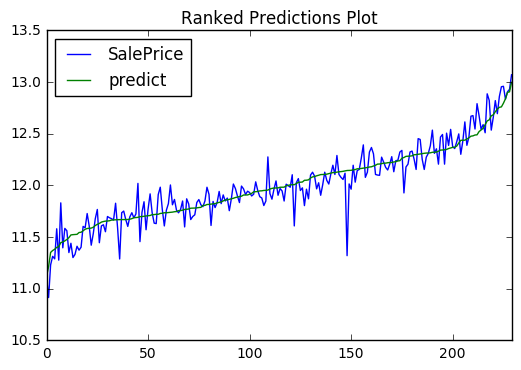

In [24]:
glm0_0 = glm_grid(original_nums, 'SalePrice', half_train, half_valid)
gen_submission(glm0_0) # Valid RMSE: ~0.1323, ~0.1445 on public leaderboard

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0    [0.99]  Grid_GLM_py_290_sid_a7cd_model_python_1497309861992_4_model_3   
1     [0.5]  Grid_GLM_py_290_sid_a7cd_model_python_1497309861992_4_model_2   
2    [0.25]  Grid_GLM_py_290_sid_a7cd_model_python_1497309861992_4_model_1   
3    [0.01]  Grid_GLM_py_290_sid_a7cd_model_python_1497309861992_4_model_0   

    residual_deviance  
0  3.3933211971158004  
1   3.402296538296244  
2  3.4124971533289354  
3   3.791603040179966  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_290_sid_a7cd_model_python_1497309861992_4_model_3


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.02227260217288583
RMSE: 0.14924008232671887
MAE: 0.1021767066612568
RMSLE: 0.011407191199535434
R^2: 0.854201320285019
Mean Residual Deviance: 0.02227260217288583
Null degrees of free

,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2017-06-12 20:11:58,0.000 sec,0,.3E0,2,0.1442675,0.1766220
,2017-06-12 20:11:58,0.001 sec,0,.28E0,2,0.1365238,0.1655749
,2017-06-12 20:11:58,0.001 sec,0,.27E0,2,0.1294652,0.1554957
,2017-06-12 20:11:58,0.002 sec,0,.26E0,2,0.1230313,0.1462994
,2017-06-12 20:11:58,0.003 sec,0,.25E0,2,0.1171668,0.1379085
---,---,---,---,---,---,---,---
,2017-06-12 20:11:58,0.086 sec,0,.38E-2,27,0.0219279,0.0149371
,2017-06-12 20:11:58,0.087 sec,0,.36E-2,27,0.0218700,0.0149759
,2017-06-12 20:11:58,0.088 sec,0,.34E-2,28,0.0218168,0.0150147
,2017-06-12 20:11:58,0.090 sec,0,.33E-2,28,0.0217677,0.0150506



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
11.7906,11.8534
11.9117,11.9847
11.9767,11.9344
11.8451,11.8394
11.1346,11.3083
11.8845,11.8418
11.9382,11.907
11.8565,11.7382
11.9704,12.0465
12.6667,12.5716



glm prediction progress: |████████████████████████████████████████████████| 100%


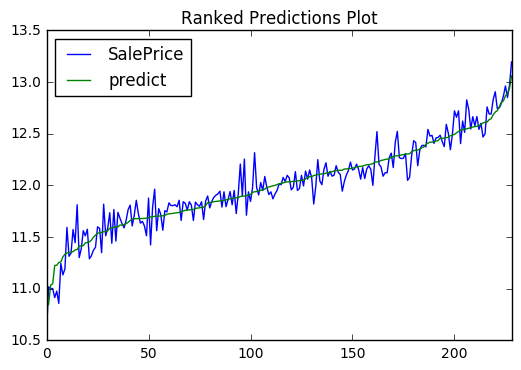

In [25]:
glm0_1 = glm_grid(original_nums, 'SalePrice', other_half_train, other_half_valid)
gen_submission(glm0_1) # Valid RMSE: 0.1492

#### Blend predictions

In [53]:
# pred_blender('../data/', 
#             ['submission_Mon_Jun_12_20_11_26_2017.csv',
#              'submission_Mon_Jun_12_20_11_59_2017.csv'])
# ~0.1434 on public leaderboard, better than single model!

     Id     SalePrice0     SalePrice1           mean
0  1461  124738.634552  118134.029399  121436.331976
1  1462  150810.027529  143712.331772  147261.179651
2  1463  171273.334078  167782.821376  169528.077727
3  1464  199029.141524  192866.913126  195948.027325
4  1465  181626.844192  189479.964501  185553.404347


#### Second model on encoded numeric inputs

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0    [0.99]  Grid_GLM_py_288_sid_a7cd_model_python_1497309861992_6_model_3   
1     [0.5]  Grid_GLM_py_288_sid_a7cd_model_python_1497309861992_6_model_2   
2    [0.25]  Grid_GLM_py_288_sid_a7cd_model_python_1497309861992_6_model_1   
3    [0.01]  Grid_GLM_py_288_sid_a7cd_model_python_1497309861992_6_model_0   

    residual_deviance  
0   3.489761978471547  
1  3.4923368774559886  
2   3.499213967313534  
3    3.99722021865948  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_288_sid_a7cd_model_python_1497309861992_6_model_3


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.015092663885340148
RMSE: 0.12285220342077771
MAE: 0.08537704547795884
RMSLE: 0.00954842714670565
R^2: 0.9036391465120837
Mean Residual Deviance: 0.015092663885340148
Null degrees of f

,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2017-06-12 20:32:07,0.000 sec,0,.31E0,2,0.1472858,0.1420261
,2017-06-12 20:32:07,0.001 sec,0,.3E0,2,0.1387711,0.1340858
,2017-06-12 20:32:07,0.002 sec,0,.29E0,2,0.1310096,0.1268453
,2017-06-12 20:32:07,0.003 sec,0,.27E0,2,0.1239348,0.1202429
,2017-06-12 20:32:07,0.004 sec,0,.26E0,2,0.1174861,0.1142224
---,---,---,---,---,---,---,---
,2017-06-12 20:32:07,0.126 sec,0,.39E-2,53,0.0144193,0.0155874
,2017-06-12 20:32:07,0.128 sec,0,.38E-2,53,0.0143704,0.0156274
,2017-06-12 20:32:07,0.129 sec,0,.36E-2,54,0.0143240,0.0156820
,2017-06-12 20:32:07,0.131 sec,0,.34E-2,54,0.0142815,0.0157522



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
11.8494,12.1127
12.2061,12.2729
11.6784,11.8203
11.914,11.7811
12.6758,12.4862
12.861,12.6811
12.1035,11.9298
11.2898,11.3454
11.7714,11.6451
11.5843,11.4854



glm prediction progress: |████████████████████████████████████████████████| 100%


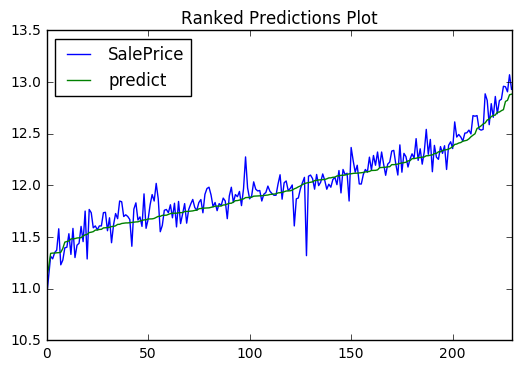

In [56]:
glm1_0 = glm_grid(encoded_nums, 'SalePrice', half_train, half_valid)
gen_submission(glm1_0) # Valid RMSE: ~0.1231, ~0.1411 on public leaderboard

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0    [0.99]  Grid_GLM_py_290_sid_a7cd_model_python_1497309861992_7_model_3   
1     [0.5]  Grid_GLM_py_290_sid_a7cd_model_python_1497309861992_7_model_2   
2    [0.25]  Grid_GLM_py_290_sid_a7cd_model_python_1497309861992_7_model_1   
3    [0.01]  Grid_GLM_py_290_sid_a7cd_model_python_1497309861992_7_model_0   

    residual_deviance  
0  3.7883232833925544  
1  3.8341808114920632  
2  3.9260833738256045  
3   4.847134992403332  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_290_sid_a7cd_model_python_1497309861992_7_model_3


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.016990442897046324
RMSE: 0.1303473931348315
MAE: 0.09068624360676654
RMSLE: 0.010021859088928282
R^2: 0.8887788627959332
Mean Residual Deviance: 0.016990442897046324
Null degrees of f

,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2017-06-12 20:32:35,0.000 sec,0,.3E0,2,0.1442675,0.1766220
,2017-06-12 20:32:35,0.001 sec,0,.28E0,2,0.1365238,0.1655749
,2017-06-12 20:32:35,0.002 sec,0,.27E0,2,0.1294652,0.1554957
,2017-06-12 20:32:35,0.003 sec,0,.26E0,2,0.1230313,0.1462994
,2017-06-12 20:32:35,0.004 sec,0,.25E0,3,0.1168420,0.1378170
---,---,---,---,---,---,---,---
,2017-06-12 20:32:35,0.117 sec,0,.38E-2,56,0.0130841,0.0222377
,2017-06-12 20:32:35,0.119 sec,0,.36E-2,56,0.0129979,0.0225005
,2017-06-12 20:32:35,0.121 sec,0,.34E-2,56,0.0129197,0.0227587
,2017-06-12 20:32:35,0.122 sec,0,.33E-2,57,0.0128465,0.0229569



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
11.7906,11.7582
11.9117,11.921
11.9767,11.8296
11.8451,11.7368
11.1346,11.2232
11.8845,11.8194
11.9382,11.8688
11.8565,11.7421
11.9704,11.9485
12.6667,12.5612



glm prediction progress: |████████████████████████████████████████████████| 100%


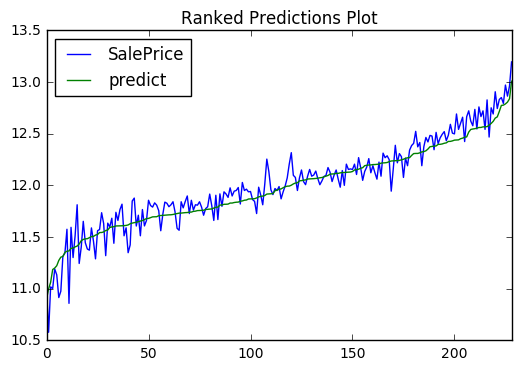

In [57]:
glm1_1 = glm_grid(encoded_nums, 'SalePrice', other_half_train, other_half_valid)
gen_submission(glm1_1) # Valid RMSE: ~0.1303

#### Blend predictions

In [58]:
# pred_blender('../data/', 
#             ['submission_Mon_Jun_12_20_32_07_2017.csv',
#              'submission_Mon_Jun_12_20_32_35_2017.csv'])
# ~0.14227 on public leaderboard, worse than single model!

     Id     SalePrice0     SalePrice1           mean
0  1461  112478.950765  103761.091904  108120.021334
1  1462  142627.401969  139321.084841  140974.243405
2  1463  165096.329612  161332.763051  163214.546331
3  1464  187988.550424  179378.655139  183683.602782
4  1465  215594.359701  221272.668277  218433.513989


#### Third model on encoded, combined numeric inputs

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                      model_ids  \
0    [0.01]  Grid_GLM_py_288_sid_a7cd_model_python_1497309861992_9_model_0   
1    [0.99]  Grid_GLM_py_288_sid_a7cd_model_python_1497309861992_9_model_3   
2    [0.25]  Grid_GLM_py_288_sid_a7cd_model_python_1497309861992_9_model_1   
3     [0.5]  Grid_GLM_py_288_sid_a7cd_model_python_1497309861992_9_model_2   

    residual_deviance  
0  3.3724141534775853  
1  3.4912572209228676  
2   3.507927534238575  
3   3.532918113135487  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_288_sid_a7cd_model_python_1497309861992_9_model_0


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.013199077295747154
RMSE: 0.11488723730574756
MAE: 0.08201469534506846
RMSLE: 0.008961616166080027
R^2: 0.9157289685151887
Mean Residual Deviance: 0.013199077295747154
Null degrees of 

,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2017-06-12 20:38:51,0.000 sec,0,.32E2,29,0.1539895,0.1482897
,2017-06-12 20:38:51,0.022 sec,0,.3E2,36,0.1490590,0.1437280
,2017-06-12 20:38:51,0.043 sec,0,.29E2,59,0.1433205,0.1384800
,2017-06-12 20:38:51,0.065 sec,0,.27E2,94,0.1364479,0.1323027
,2017-06-12 20:38:51,0.090 sec,0,.26E2,112,0.1292949,0.1259155
---,---,---,---,---,---,---,---
,2017-06-12 20:39:02,11.020 sec,0,.4E0,685,0.0123029,0.0158595
,2017-06-12 20:39:02,11.260 sec,0,.38E0,671,0.0121799,0.0161793
,2017-06-12 20:39:02,11.501 sec,0,.36E0,666,0.0120590,0.0165286
,2017-06-12 20:39:03,11.740 sec,0,.35E0,663,0.0119419,0.0169070



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
11.8494,12.0939
12.2061,12.1972
11.6784,11.8073
11.914,11.7929
12.6758,12.4611
12.861,12.662
12.1035,11.9519
11.2898,11.3795
11.7714,11.6673
11.5843,11.5341



glm prediction progress: |████████████████████████████████████████████████| 100%


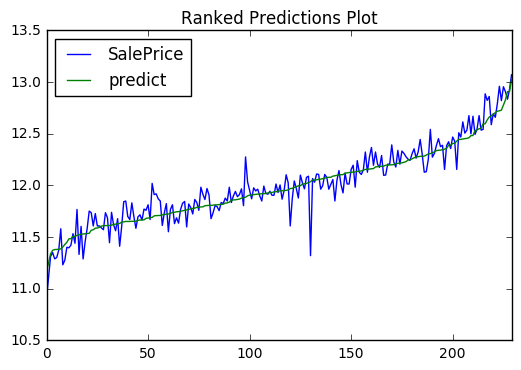

In [60]:
glm2_0 = glm_grid(encoded_combined_nums, 'SalePrice', half_train, half_valid)
gen_submission(glm2_0) # Valid RMSE: ~0.1212, ~0.1406 on public leaderboard

glm Grid Build progress: |████████████████████████████████████████████████| 100%
      alpha                                                       model_ids  \
0    [0.99]  Grid_GLM_py_290_sid_a7cd_model_python_1497309861992_10_model_3   
1     [0.5]  Grid_GLM_py_290_sid_a7cd_model_python_1497309861992_10_model_2   
2    [0.25]  Grid_GLM_py_290_sid_a7cd_model_python_1497309861992_10_model_1   
3    [0.01]  Grid_GLM_py_290_sid_a7cd_model_python_1497309861992_10_model_0   

    residual_deviance  
0  3.4590219515926783  
1  3.4826346848444336  
2   3.511336362289371  
3  3.8108902244118315  
None
Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_py_290_sid_a7cd_model_python_1497309861992_10_model_3


ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.012012531421225717
RMSE: 0.10960169442680034
MAE: 0.07905747054357373
RMSLE: 0.008532514838581357
R^2: 0.9213647688018438
Mean Residual Deviance: 0.012012531421225717
Null degre

,timestamp,duration,iteration,lambda,predictors,deviance_train,deviance_test
,2017-06-12 20:39:55,0.000 sec,0,.31E0,3,0.1435963,0.1782125
,2017-06-12 20:39:55,0.021 sec,0,.29E0,3,0.1346252,0.1671305
,2017-06-12 20:39:55,0.041 sec,0,.28E0,3,0.1264398,0.1569870
,2017-06-12 20:39:55,0.061 sec,0,.27E0,5,0.1184455,0.1468780
,2017-06-12 20:39:55,0.083 sec,0,.26E0,5,0.1107452,0.1371094
---,---,---,---,---,---,---,---
,2017-06-12 20:39:58,3.571 sec,0,.39E-2,88,0.0093512,0.0164983
,2017-06-12 20:39:58,3.625 sec,0,.37E-2,95,0.0092507,0.0165218
,2017-06-12 20:39:58,3.682 sec,0,.35E-2,99,0.0091413,0.0165399
,2017-06-12 20:39:59,3.739 sec,0,.34E-2,101,0.0090200,0.0165967



See the whole table with table.as_data_frame()

glm prediction progress: |████████████████████████████████████████████████| 100%


SalePrice,predict
11.7906,11.7262
11.9117,11.8984
11.9767,11.8263
11.8451,11.7014
11.1346,11.1494
11.8845,11.8036
11.9382,11.9082
11.8565,11.7435
11.9704,11.9705
12.6667,12.5162



glm prediction progress: |████████████████████████████████████████████████| 100%


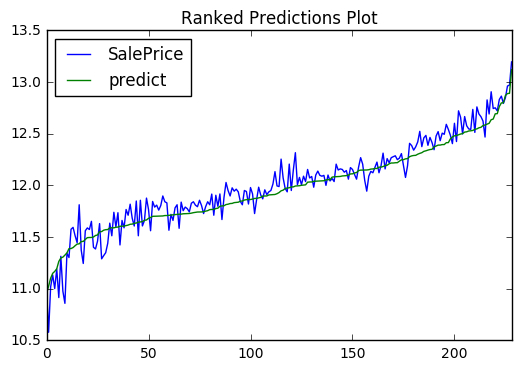

In [61]:
glm2_1 = glm_grid(encoded_combined_nums, 'SalePrice', other_half_train, other_half_valid)
gen_submission(glm2_1) # Valid RMSE: ~0.1229

#### Blend predictions

In [62]:
# pred_blender('../data/', 
#             ['submission_Mon_Jun_12_20_39_23_2017.csv',
#              'submission_Mon_Jun_12_20_40_00_2017.csv'])
# ~0.1382 on public leaderboard, better than single model!

     Id     SalePrice0     SalePrice1           mean
0  1461  112885.363490  102731.828721  107808.596105
1  1462  146536.471731  143795.823801  145166.147766
2  1463  167849.718034  159372.817318  163611.267676
3  1464  192079.947227  177332.427474  184706.187351
4  1465  214387.785910  205604.514950  209996.150430


In [25]:
# Shutdown H2O - this will erase all your unsaved frames and models in H2O
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? y
H2O session _sid_8451 closed.
